In [1]:
# Import Core Packages
%load_ext autoreload
%autoreload 2

import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import sys
import os
from pathlib import Path
import platform
import shutil

In [2]:
basepath = Path(r'E:\Data\PCDisruption\Strawberry\Stb_2024-10-27_LeMans')
animal = basepath.parent.name
# Get current OS and set paths dependent on working OS.
cur_system = platform.system()
cur_dir = Path(os.getcwd())

if cur_system == "Linux":  # For Linux
    sys.path.extend(['/home/kimqi/Documents/Repositories/NeuroPy'])  # NeuroPy Path
    # Directories 

elif cur_system == "Windows":
    sys.path.extend([r'E:\Code\Repositories\NeuroPy'])  # NeuroPy Path
    
    cur_folder = Path(basepath).name
    session_name = re.sub(r'_\d{4}-\d{2}-\d{2}_', '_', cur_folder)
    save_dir = Path('E:\Analyses\Preliminary')
    save_dir = Path(save_dir / animal)

save_dir = Path(save_dir / cur_folder)
plot_dir = Path(save_dir / 'Plots')


save_dir.mkdir(parents=True, exist_ok=True)
plot_dir.mkdir(parents=True, exist_ok=True)

print(basepath)
print(cur_folder)
print(session_name)
print(save_dir)
print(plot_dir)

E:\Data\PCDisruption\Strawberry\Stb_2024-10-27_LeMans
Stb_2024-10-27_LeMans
Stb_LeMans
E:\Analyses\Preliminary\Strawberry\Stb_2024-10-27_LeMans
E:\Analyses\Preliminary\Strawberry\Stb_2024-10-27_LeMans\Plots


In [113]:
# Import NeuroPy Packages

# Analyses
from neuropy.analyses import oscillations
from neuropy.analyses.spkepochs import detect_pbe_epochs
from neuropy.analyses import placefields

# Core
from neuropy import core

from neuropy.core import Epoch
from neuropy.core import Neurons
from neuropy.core import Position
from neuropy.core.neurons import binned_pe_raster
from neuropy.core.neurons import pe_raster

from neuropy.core import BinnedSpiketrain
from neuropy.core import Shank, Probe, ProbeGroup

from neuropy.core.session import ProcessData

# IO
from neuropy.io import PhyIO

from neuropy.io.binarysignalio import BinarysignalIO
from neuropy.io.openephysio import get_dat_timestamps
from neuropy.io.openephysio import load_all_ttl_events

# Plotting
from neuropy.plotting import plot_probe
from neuropy.plotting import Fig
from neuropy.plotting import spikes
from neuropy.plotting.ratemaps import plot_ratemap

from neuropy.plotting.signals import plot_signal_traces

# Utils

from neuropy.utils import neurons_util
from neuropy.utils.ccg import correlograms
from neuropy.utils.mathutil import contiguous_regions
from neuropy.utils.signal_process import filter_sig
from neuropy.utils import position_util

import neuropy.io.optitrackio as optiio
import neuropy.io.openephysio as oeio

In [4]:
sess_folder = Path(r"E:\Data\PCDisruption\Strawberry\Stb_2024-10-27_LeMans\2024-10-27_12-58-28\Record Node 104")

settings_path = oeio.get_settings_file(sess_folder)
print(settings_path)
rec_df = oeio.create_sync_df(sess_folder)
rec_df

E:\Data\PCDisruption\Strawberry\Stb_2024-10-27_LeMans\2024-10-27_12-58-28\Record Node 104\settings.xml
start time = 2024-10-27 12:58:28.836000-04:00
start time = 2024-10-27 13:04:07.234000-04:00
start time = 2024-10-27 13:08:56.940000-04:00
start time = 2024-10-27 13:50:37.149000-04:00


,Recording,Datetime,Condition,nframe_dat,dat_time,nframe_eeg,eeg_time
0,0,2024-10-27 12:58:28.836000-04:00,start,0,0.000000,0,0.0000
1,0,2024-10-27 13:04:06.918100-04:00,stop,10142463,338.082100,422602,338.0816
2,1,2024-10-27 13:04:07.234000-04:00,start,10142464,338.082133,422603,338.0824
3,1,2024-10-27 13:08:53.476100-04:00,stop,18729727,624.324233,780405,624.3240
4,2,2024-10-27 13:08:56.940000-04:00,start,18729728,624.324267,780406,624.3248
5,2,2024-10-27 13:50:36.822633333-04:00,stop,93726207,3124.206900,3905258,3124.2064
6,3,2024-10-27 13:50:37.149000-04:00,start,93726208,3124.206933,3905259,3124.2072
7,3,2024-10-27 13:52:40.711633333-04:00,stop,97433087,3247.769567,4059711,3247.7688


In [114]:
event_dir = Path(r"E:\Data\PCDisruption\Strawberry\Stb_2024-10-27_LeMans\2024-10-27_12-58-28\Record Node 104\experiment1\recording1\events\RHD_Rec_Controller-100.Rhythm Data\TTL")

#rec_start = rec_df.loc[4, "Datetime"]
opti_obj = optiio.OptitrackIO(basepath) # Load in optitrack position data from .csv
opti_obj.datetime_array = opti_obj.datetime_array.tz_localize("America/Detroit")
ttl_dict = oeio.load_ttl_events(event_dir)  # Load in TTL data
ttl_dict['start_time']

E:\Data\PCDisruption\Strawberry\Stb_2024-10-27_LeMans\Take 2024-10-27 01.04.02.csv


datetime.datetime(2024, 10, 27, 12, 58, 28, 836000, tzinfo=tzfile('America/Detroit'))

In [115]:
start_datetime = rec_df.loc[2, 'Datetime']
t_start = rec_df.loc[2, 'dat_time']
t_stop = rec_df.loc[5, 'dat_time']
print(start_datetime)
print(t_start)
print(t_stop)

2024-10-27 13:04:07.234000-04:00
338.08213333333333
3124.2069


In [116]:
motive_ttl_channel = 2
motive_start_frame = ttl_dict["timestamps"][np.where(ttl_dict["channel_states"] == motive_ttl_channel)[0][0]]
motive_start_datetime = ttl_dict['start_time'] + pd.to_timedelta(motive_start_frame / ttl_dict["SR"], unit="sec")
print(motive_start_datetime)

2024-10-27 13:04:02.579633-04:00


In [117]:
print(len(opti_obj.x))

83969


In [118]:
opti_obj.remove_negatives(ref_time=start_datetime)

In [120]:
# Now subtract to get absolute time passed in seconds from recording start
motive_times_from_oe_rec_start = (opti_obj.datetime_array - start_datetime).total_seconds()
motive_times_from_oe_rec_start

Float64Index([   0.016667,        0.05,    0.083333,    0.116667,        0.15,
                 0.183333,    0.216667,        0.25,    0.283333,    0.316667,
              ...
              2793.883333, 2793.916667,     2793.95, 2793.983333, 2794.016667,
                  2794.05, 2794.083333, 2794.116667,     2794.15, 2794.183333],
             dtype='float64', length=83826)

In [121]:
#print(opti_obj.datetime_array)
print(len(opti_obj.datetime_array))
print(opti_obj.datetime_starts)
print(opti_obj.datetime_stops)
print(opti_obj.datetime_nframes)

83826
2024-10-27 13:04:07.250667-04:00
2024-10-27 13:50:41.417333-04:00
83826


In [122]:
sess = ProcessData(basepath)
phy_dir = sorted(sess.basepath.glob("**/params.py"))[0].parent
sess.phy = PhyIO(dirname=phy_dir)
sess.neurons = Neurons(sess.phy.spiketrains, t_stop=sess.eegfile.duration, neuron_ids=sess.phy.neuron_ids,
                       neuron_type=sess.phy.cluster_info["group"], waveforms=sess.phy.waveforms, 
                       waveforms_amplitude=sess.phy.waveforms_amplitude, sampling_rate=sess.recinfo.dat_sampling_rate,
                       peak_channels=sess.phy.peak_channels, clu_q=sess.phy.clu_q, shank_ids=sess.phy.shank_ids)

id column does not exist in cluster_info.tsv. Using cluster_id column instead.


In [123]:
pfs = sess.neurons.time_slice(t_start=t_start, t_stop=t_stop, zero_spike_times=True)
motive_sr = 30
pos2d = np.array([opti_obj.x, opti_obj.y]) # create a 2 x nframes array of x/y positions 

pos = Position(traces=pos2d, t_start=0, sampling_rate=motive_sr)
pos = position_util.linearize_position(pos)

In [124]:
pos.duration

2794.2

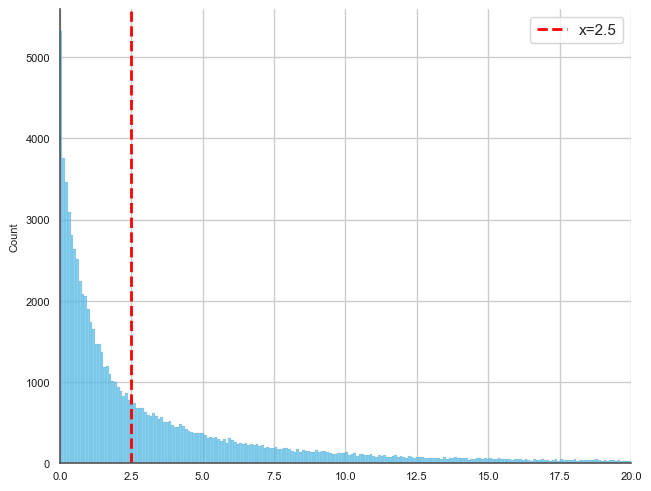

In [129]:
test_place_cells = placefields.Pf1D(neurons=pfs, position=pos, speed_thresh=3)
import seaborn as sns
import matplotlib.pyplot as plt

# Example data (replace 'test_place_cells.speed' with your actual data)
speed_data = test_place_cells.speed  # Replace this with your actual data

# Plot histogram using seaborn
sns.histplot(speed_data, bins=1000, kde=False, edgecolor="black")

# Draw vertical line at x=3
plt.axvline(x=2.5, color='red', linestyle='--', linewidth=2, label='x=2.5')

# Set x-axis limits
plt.xlim(0, 20)

# Add legend for clarity
plt.legend()

# Show the plot
plt.show()

(26.5, 27.5)

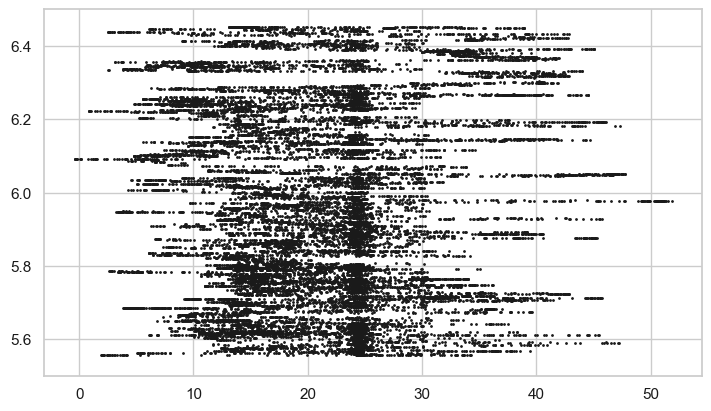

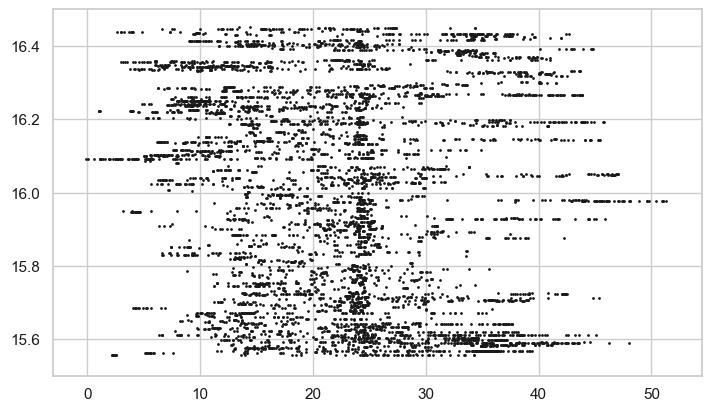

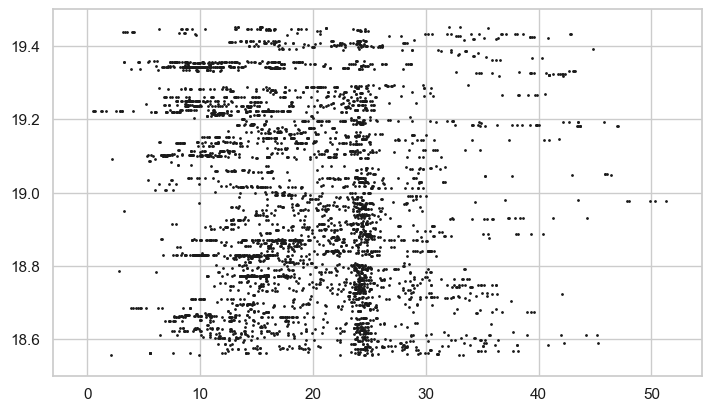

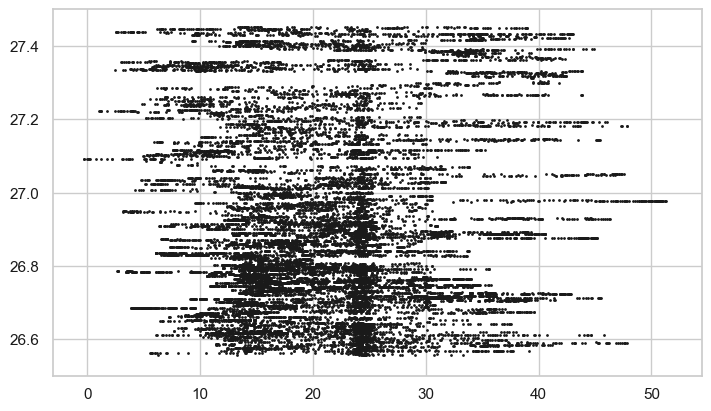

In [134]:
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(7,4))
test_place_cells.plot_ratemaps_raster(ax=ax,plot_time=True)
ax.set_ylim([5.5, 6.5])

fig, ax = plt.subplots(figsize=(7,4))
test_place_cells.plot_ratemaps_raster(ax=ax,plot_time=True)
ax.set_ylim([15.5, 16.5])

fig, ax = plt.subplots(figsize=(7,4))
test_place_cells.plot_ratemaps_raster(ax=ax,plot_time=True)
ax.set_ylim([18.5, 19.5])

fig, ax = plt.subplots(figsize=(7,4))
test_place_cells.plot_ratemaps_raster(ax=ax,plot_time=True)
ax.set_ylim([26.5, 27.5])

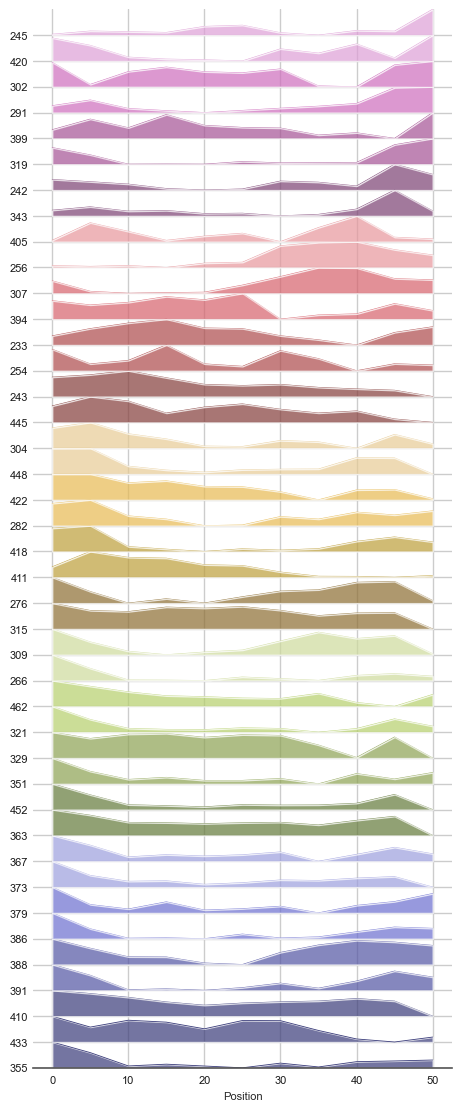

In [131]:
import matplotlib.pyplot as plt

# Plot the ratemaps using the method from Pf1D
ax2 = plot_ratemap(test_place_cells, normalize_tuning_curve=True)

In [138]:
test_place_cells.occupancy

array([  7.93351805,  57.50023354, 169.73300216, 193.10016261,
       260.09936697, 157.23341209,  75.50024111,  58.46662269,
        29.6333578 ,   7.36672791,   1.53335507])

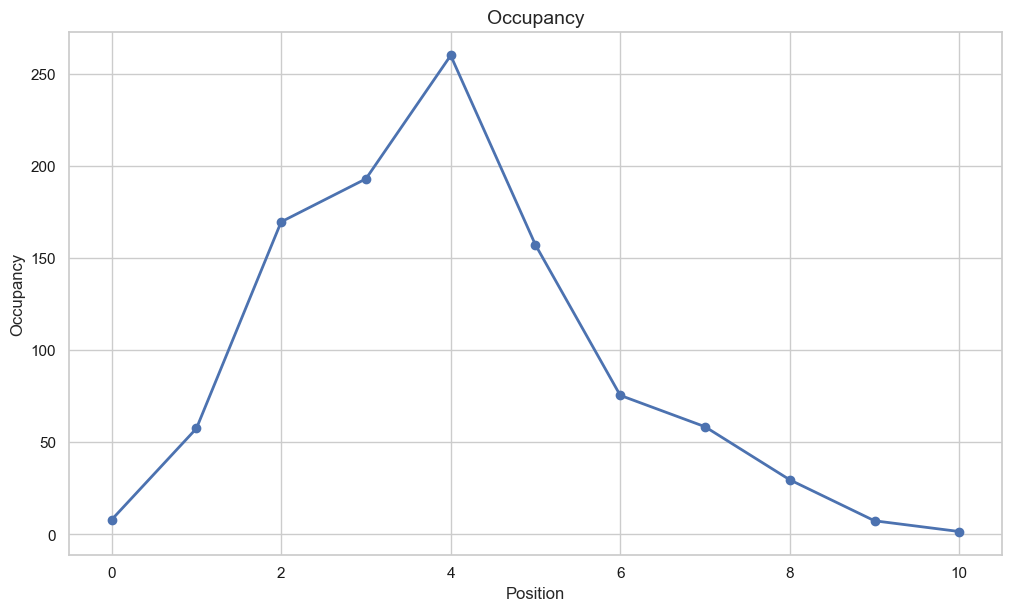

In [139]:
plt.figure(figsize=(10, 6))
plt.plot(test_place_cells.occupancy, marker='o', linestyle='-', linewidth=2)
plt.title("Occupancy", fontsize=14)
plt.xlabel("Position", fontsize=12)
plt.ylabel("Occupancy", fontsize=12)
plt.grid(True)
plt.show()